In [15]:
import numpy as np
from scipy.sparse import coo_matrix
import math

def construct_X(M, alphas, Np=None):
    # If Np is not given, choose a value large enough to fit the diagonal of the image
    if Np is None:
        Np = int(math.ceil(math.sqrt(2) * M))

    D = M * M
    N = Np * len(alphas)
    h = 1  # pixel distance

    # Create an array C holding the coordinates of the tomogram's pixel centers
    ja, jb = np.mgrid[0:M, 0:M]
    j = ja + M * jb
    C = np.array([ja.flatten(), jb.flatten()])
    j = j.flatten()  # Flatten the j array

    # Initialize arrays to store the indices and weights for the sparse matrix
    i_indices = []
    j_indices = []
    weights = []

    for i, alpha in enumerate(alphas):
        # Convert alpha from degrees to radians
        alpha_rad = np.deg2rad(alpha)

        # Define the unit vector n along the rotated sensor
        n = np.array([np.cos(alpha_rad), np.sin(alpha_rad)])

        # Compute the projection p of each pixel onto the sensor
        s0 = (Np - 1) / 2  # distance between the first sensor element and the sensor's coordinate origin
        p = np.dot(n, C) + s0

        # Compute the weights X for each angle from p
        i_lower = np.floor(p).astype(int)
        i_upper = i_lower + 1
        weight_upper = p - i_lower
        weight_lower = 1 - weight_upper

        # Add the indices and weights to the arrays
        for i_sensor in [i_lower, i_upper]:
            valid = (i_sensor >= 0) & (i_sensor < Np)
            i_indices.append(i * Np + i_sensor[valid])  # Corrected this line
            j_indices.append(j[valid])
            weights.append((weight_lower if i_sensor is i_lower else weight_upper)[valid])

    # Convert the lists to numpy arrays
    i_indices = np.concatenate(i_indices)
    j_indices = np.concatenate(j_indices)
    weights = np.concatenate(weights)

    # Construct the sparse matrix X
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)

    return X


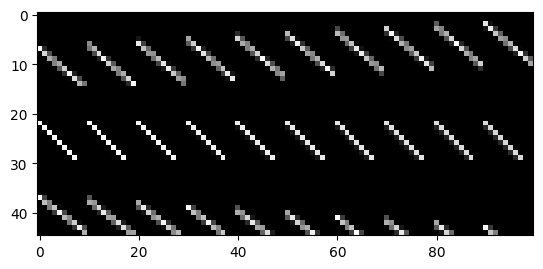

In [17]:
import matplotlib.pyplot as plt

X = construct_X(10, [-33,1,42])
plt.imshow(X.toarray(),cmap='gray')
plt.show()



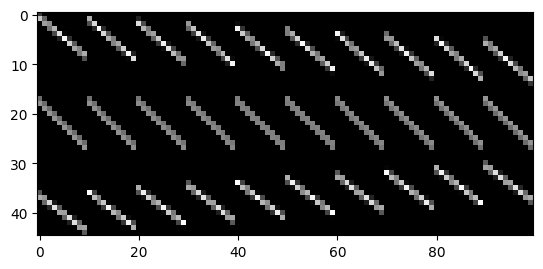

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

def load_npy_file(file_path):
    # Load the .npy file
    data = np.load(file_path)
    
    return data

def sparse_to_dense(sparse_matrix):
    # Convert the sparse matrix to a dense numpy-array
    dense_matrix = sparse_matrix.toarray()
    
    return dense_matrix

def visualize_data(data):
    # Visualize the data
    plt.imshow(data, cmap='gray')
    plt.show()

# Test the functions
file_path = '../hs_tomography/x_example.npy'  # Replace with your actual file path
sparse_data = load_npy_file(file_path)

# Convert the sparse matrix to a dense numpy-array
dense_data = sparse_to_dense(csc_matrix(sparse_data))

# Visualize the dense data
visualize_data(dense_data)


### 2 Recovering the image ( 9 points)

The material for this sheet contains the list of angles and the measured sensor data $\mathbf{y}$ for two versions of the experiment. The smaller one was created with $M=77, N_p=109$ and 90 projection angles. The larger one was created with $M=195, N_p=275$ and 179 projection angles. The exact set of angles and the corresponding response vectors $\mathbf{y}$ can be found in the data-zip as 'alphas_77.npy' and 'y_195.npy' resp. 'alphas_195.npy' and 'y_77.npy' (in folder 'hs_tomography'). We recommend the smaller version of the data for debugging your code. However, its resolution is insufficient to diagnose the cause of your patient's headache. If you can recognize the head in the small tomogram, your code is probably correct, and you should switch to the larger version.

Exactly how many non-zero entries does $\mathbf{X}$ have? Use scipy's tools to find out and report the sparsity of $\mathbf{X}$.

With the ability to construct the matrix $\mathbf{X}$ and having obtained a set of projections $\mathbf{y}$, you are now able to reconstruct the original image $\boldsymbol{\beta}$. In theory, you could try to solve the equation system directly via the pseudo-inverse
$$
\boldsymbol{\beta}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \cdot \mathbf{X}^{\top} \cdot \mathbf{y},
$$
But this is not recommended because it ignores sparsity and is therefore very slow.
Fortunately, Scipy already gives you access to efficient solvers for sparse linear equation systems! Find out how to use scipy.sparse.linalg.lsqr() to obtain the least-squares solution to your problem. The solver's low default tolerance parameters atol $=1 \mathrm{e}-08$ and btol $=1 \mathrm{e}-08$ lead to high quality solutions, but also long computation times on the large version of the data. A good trade-off might be atol $=\mathrm{btol}=1 \mathrm{e}-05$, but you can reduce the tolerance once you are confident that your code is correct.

Reconstruct the tomogram and plot it as a 2D image. Give a diagnosis on what causes H.S.'s headache and propose a treatment.

If you didn't manage to correctly construct $\mathbf{X}$ in task 1 , you can find a precomputed weight matrix for the smaller version of the experiment in 'hs_tomography/X_77.npy' and use it for this task. You can load it with $X=n p$.load('hs_tomography/X_77.npy', allow_pickle=True) and convert it to a sparse matrix with $X=$ scipy.sparse.csc_matrix $(X . a l l())$.

To solve this task, you can follow these steps:

Load the data: Load the list of angles and the measured sensor data y from the provided files.

Construct the matrix X: Use the construct_X function you implemented in the previous task to construct the matrix X.

Calculate the sparsity of X: The sparsity of a matrix is the proportion of zero elements in the matrix. You can calculate it using the scipy.sparse library.

Solve the equation: Use the scipy.sparse.linalg.lsqr() function to solve the equation and obtain the least-squares solution. This will give you the reconstructed image.

Visualize the result: Plot the reconstructed image as a 2D image.

Sparsity of X: 0.9863648828500491


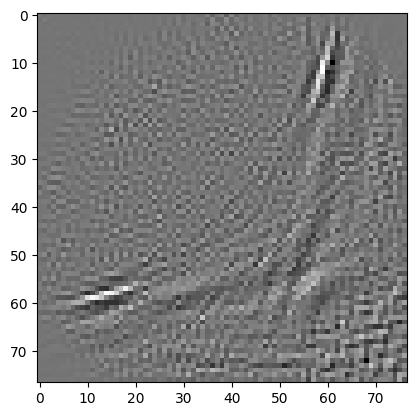

In [18]:
import numpy as np
from scipy.sparse.linalg import lsqr
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

# Load the data
alphas = np.load('../hs_tomography/alphas_77.npy')
y = np.load('../hs_tomography/y_77.npy')
M = 77
Np = 109

# Construct the matrix X
X = construct_X(M, alphas, Np)

# Calculate the sparsity of X
sparsity = 1.0 - X.nnz / (X.shape[0] * X.shape[1])
print(f'Sparsity of X: {sparsity}')

# Solve the equation
beta = lsqr(X, y, atol=1e-05, btol=1e-05)

# Reshape the solution to a 2D array
beta = beta[0].reshape((M, M))

# Visualize the result
plt.imshow(beta, cmap='gray')
plt.show()


Sparsity of X: 0.9946372326618137


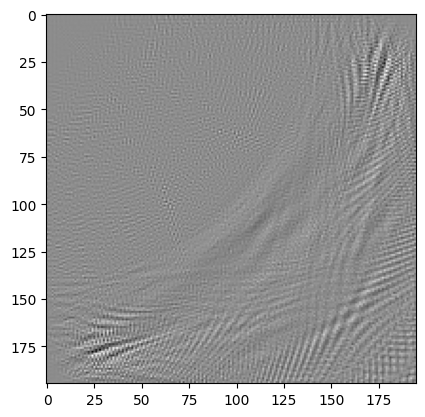

In [19]:
alphas = np.load('../hs_tomography/alphas_195.npy')
y = np.load('../hs_tomography/y_195.npy')
M = 195
Np = 275

# Construct the matrix X
X = construct_X(M, alphas, Np)

# Calculate the sparsity of X
sparsity = 1.0 - X.nnz / (X.shape[0] * X.shape[1])
print(f'Sparsity of X: {sparsity}')

# Solve the equation
beta = lsqr(X, y, atol=1e-05, btol=1e-05)

# Reshape the solution to a 2D array
beta = beta[0].reshape((M, M))

# Visualize the result
plt.imshow(beta, cmap='gray')
plt.show()

Sparsity of X: 98.17%


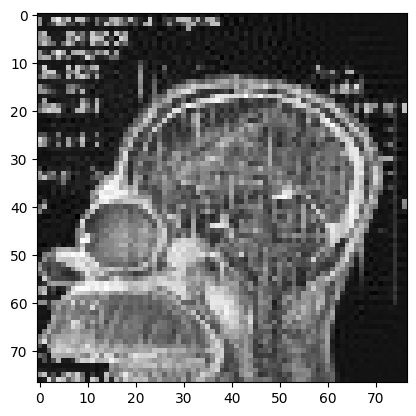

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr
from scipy.sparse import csc_matrix

# Load the data
alphas = np.load('../hs_tomography/alphas_77.npy')
y = np.load('../hs_tomography/y_77.npy')
M = 77
Np = 109

# Load the precomputed matrix X
X = np.load('../hs_tomography/X_77.npy', allow_pickle=True)
X = csc_matrix(X.all())

# Report the sparsity of X
nnz = X.nnz  # number of non-zero entries
total = X.shape[0] * X.shape[1]  # total number of entries
sparsity = 1 - nnz / total
print(f'Sparsity of X: {sparsity * 100:.2f}%')

# Use scipy's lsqr function to solve the system of equations
result = lsqr(X, y, atol=1e-05, btol=1e-05)
beta = result[0]  # the solution is the first element of the result

# Reshape the solution into a 2D image
image = beta.reshape((M, M))

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()


## 3 Minimizing the radiation dose (9 points)

As a doctor, you do not want to expose your patients to unnecessary radiation. Try to reduce the number of projection angles in a sensible way and visualize how this changes the quality of the reconstruction. In the case of H.S., what would you say is the minimal number of projections that still allows you to resolve the cause of his headache?

To minimize the radiation dose, we can reduce the number of projection angles used in the computed tomography (CT) scan. However, reducing the number of projections will also reduce the quality of the reconstructed image. The challenge is to find a balance between minimizing radiation exposure and maintaining sufficient image quality for diagnosis.

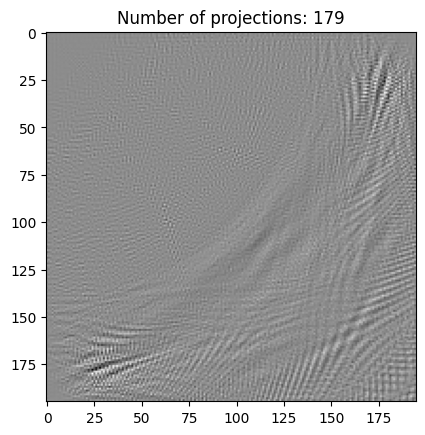

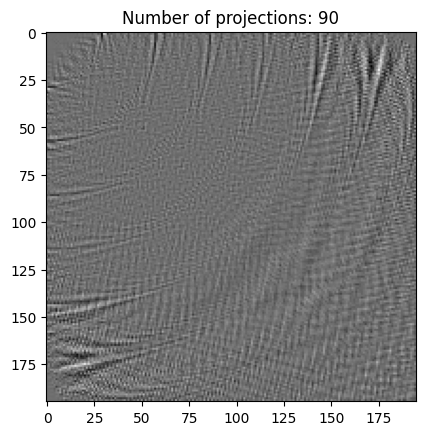

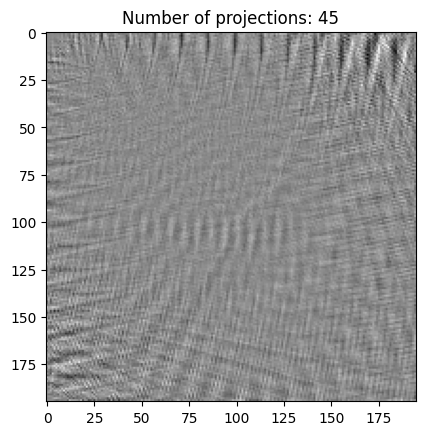

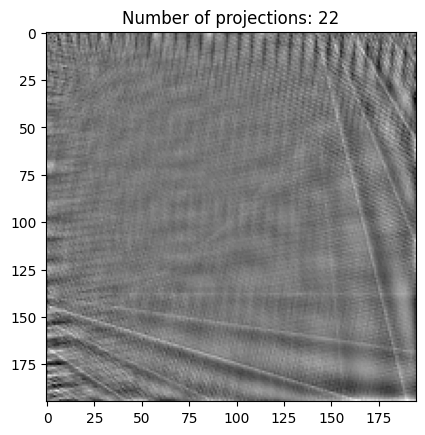

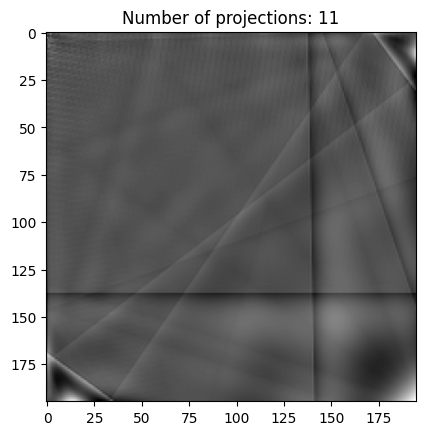

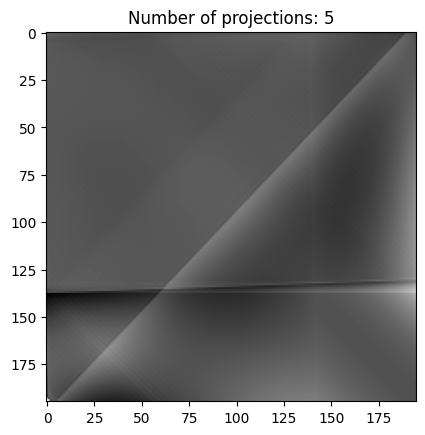

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr
from scipy.sparse import csc_matrix

# Load the data
alphas = np.load('../hs_tomography/alphas_195.npy')
y = np.load('../hs_tomography/y_195.npy')
M = 195
Np = 275

# Try different numbers of projections
for num_projections in [179, 90, 45, 22, 11, 5]:
    # Select a subset of the angles and corresponding measurements
    alphas_subset = np.linspace(alphas.min(), alphas.max(), num_projections)
    y_subset = y[:Np * num_projections]

    # Construct the matrix X
    X = construct_X(M, alphas_subset, Np)

    # Use scipy's lsqr function to solve the system of equations
    result = lsqr(X, y_subset, atol=1e-05, btol=1e-05)
    beta = result[0]  # the solution is the first element of the result

    # Reshape the solution into a 2D image
    image = beta.reshape((M, M))

    # Plot the image
    plt.figure()
    plt.title(f'Number of projections: {num_projections}')
    plt.imshow(image, cmap='gray')
    plt.show()
